In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("/content/soil_data_incl_rain_v3.csv")
print("Columns:", df.columns)

Columns: Index(['Time', 'Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Soil_Moisture',
       'Dew_Point'],
      dtype='object')


In [ ]:
df.head()

,Time,Humidity,Atmospheric_Temp,Soil_Temp,Soil_Moisture,Dew_Point
0,2017-06-11 21:00:21+00:00,25.252367,15.487149,12.457884,63.077305,23.918315
1,2017-06-11 22:00:21+00:00,33.304246,12.115891,8.514263,40.097357,31.542544
2,2017-06-11 23:00:21+00:00,24.072051,17.319203,11.913326,100.141916,21.142841
3,2017-06-12 00:00:21+00:00,45.026218,15.865805,14.700958,64.638742,42.217799
4,2017-06-12 01:00:21+00:00,41.490917,13.842739,8.495549,97.964697,38.257137


In [ ]:
features = ['Humidity','Atmospheric_Temp','Soil_Temp',
            'Soil_Moisture','Dew_Point']

In [ ]:
df = df[['Time'] + features]
df['Time'] = pd.to_datetime(df['Time'], utc=True)
df = df.sort_values(by='Time').reset_index(drop=True)
df = df.set_index('Time').resample('1H').mean().interpolate()
df = df.reset_index()
df = df.fillna(df.mean())

/tmp/ipython-input-3964768390.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('Time').resample('1H').mean().interpolate()


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['Time'] = df['Time'].values

In [ ]:
def create_sequences(data, time_steps=30):
    seqs = []
    for i in range(len(data) - time_steps):
        seqs.append(data[i:i+time_steps])
    return np.array(seqs)

TIME_STEPS = 30
sequence_data = create_sequences(scaled_data, TIME_STEPS)
train_size = int(0.8 * len(sequence_data))
X_train, X_test = sequence_data[:train_size], sequence_data[train_size:]

In [ ]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(n_features, activation='linear', return_sequences=True)(decoded)

model = Model(inputs, decoded)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 30, 5)          │         1,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,344 (204.47 KB)

 Trainable params: 52,344 (204.47 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train, X_train,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    verbose=1,
    callbacks=[es]
)

Epoch 1/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5038 - val_loss: 0.4960
Epoch 2/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5016 - val_loss: 0.4938
Epoch 3/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5025 - val_loss: 0.4862
Epoch 4/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4935 - val_loss: 0.4816
Epoch 5/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4889 - val_loss: 0.4869
Epoch 6/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4837 - val_loss: 0.4799
Epoch 7/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4784 - val_loss: 0.4728
Epoch 8/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4793 - val_loss: 0.4877
Epoch 9/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4734 - val_loss: 0.4701
Epoch 10/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4721 - val_loss: 0.4616
Epoch 11/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4663 - val_loss: 0.4541
Epoch 12/80
175/175 ━━━━━━━━━━━━━━━━━━━━ 

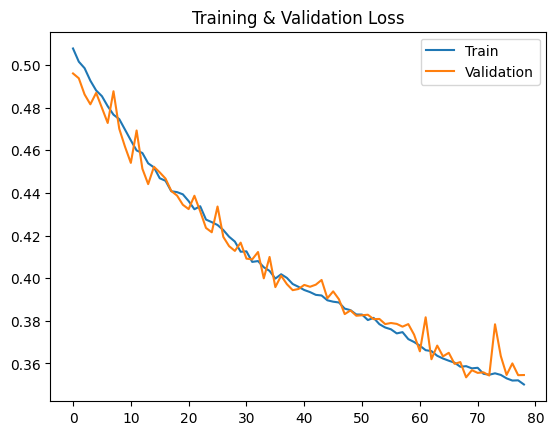

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(); plt.title("Training & Validation Loss"); plt.show()

In [ ]:
X_pred = model.predict(X_test)

# Full reconstruction error per feature per sequence
feature_mse = np.mean(np.power(X_test - X_pred, 2), axis=1)  # shape: (samples, features)
overall_mse = np.mean(feature_mse, axis=1)                   # shape: (samples,)

# Dynamic threshold
threshold = np.mean(overall_mse) + 3*np.std(overall_mse)
print("Reconstruction error threshold:", threshold)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Reconstruction error threshold: 0.5705235481377491


Detected 5 anomalies out of 1747 sequences


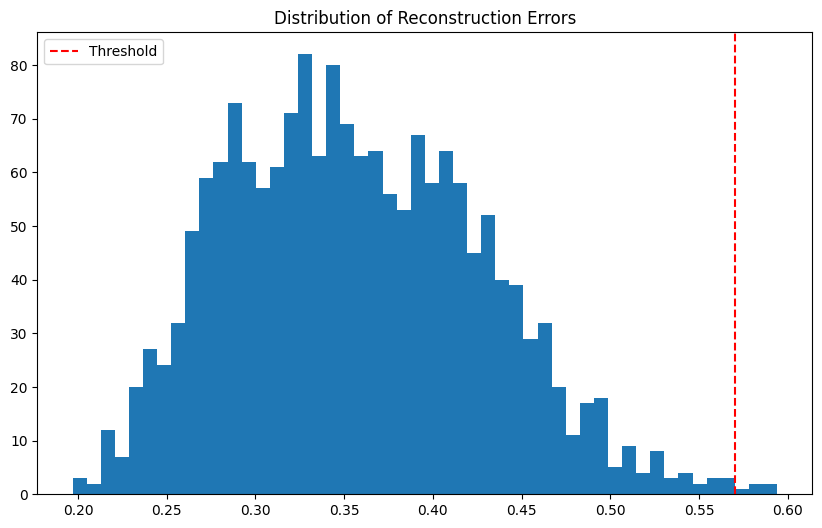

In [ ]:
#  Detect Anomalies

anomalies = overall_mse > threshold
print(f"Detected {np.sum(anomalies)} anomalies out of {len(overall_mse)} sequences")

plt.figure(figsize=(10,6))
plt.hist(overall_mse, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend(); plt.title("Distribution of Reconstruction Errors"); plt.show()


In [ ]:
#  Combine with timestamps

timestamps = df['Time'][TIME_STEPS + train_size:].reset_index(drop=True)

results = pd.DataFrame(feature_mse, columns=features)
results['timestamp'] = timestamps
results['overall_mse'] = overall_mse
results['anomaly'] = anomalies

print(results.head())

   Humidity  Atmospheric_Temp  Soil_Temp  Soil_Moisture  Dew_Point  \
0  0.180198          0.465302   0.384297       1.070775   0.200419   
1  0.068854          0.430435   0.332490       1.153719   0.082098   
2  0.070644          0.494134   0.297176       1.061165   0.083517   
3  0.079282          0.359101   0.350788       1.095969   0.092183   
4  0.071426          0.272531   0.393296       0.802162   0.071441   

                  timestamp  overall_mse  anomaly  
0 2018-03-31 03:00:00+00:00     0.460198    False  
1 2018-03-31 04:00:00+00:00     0.413519    False  
2 2018-03-31 05:00:00+00:00     0.401327    False  
3 2018-03-31 06:00:00+00:00     0.395465    False  
4 2018-03-31 07:00:00+00:00     0.322171    False  


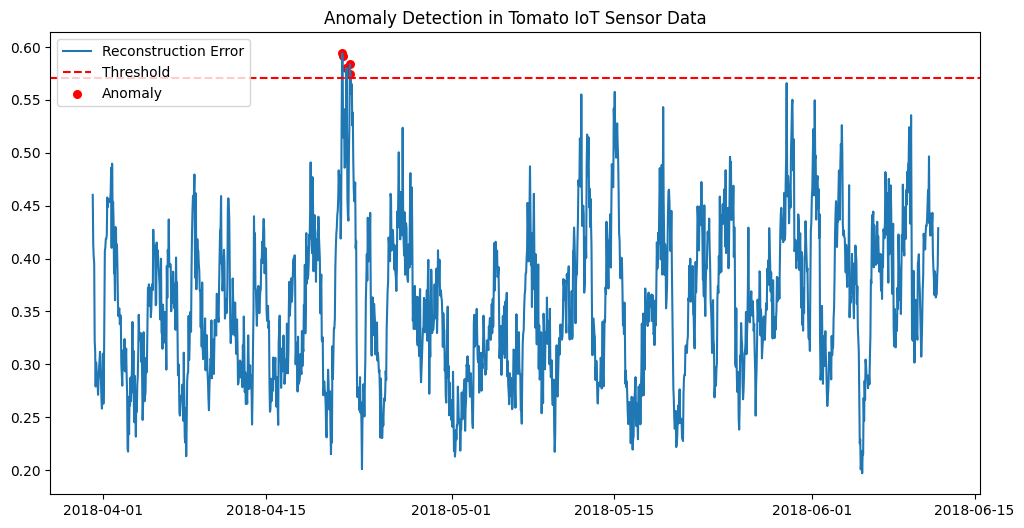

In [ ]:
# Visualize anomalies over time

plt.figure(figsize=(12,6))
plt.plot(results['timestamp'], results['overall_mse'], label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(results[results['anomaly']]['timestamp'],
            results[results['anomaly']]['overall_mse'],
            color='red', label='Anomaly', s=30)
plt.legend(); plt.title("Anomaly Detection in Tomato IoT Sensor Data"); plt.show()

In [ ]:

#  Feature-level Attribution Visualization

def explain_anomaly(row, top_k=2):
    # Ensure we’re only using numeric columns
    feature_errors = row[features].astype(float)
    top_feats = feature_errors.nlargest(top_k).index.tolist()
    return ", ".join(top_feats)

results['top_features'] = results.apply(explain_anomaly, axis=1)

# Display top anomalies
print(results[results['anomaly']][['timestamp','top_features','overall_mse']].head())


                    timestamp                     top_features  overall_mse
515 2018-04-21 14:00:00+00:00         Soil_Moisture, Soil_Temp     0.594039
516 2018-04-21 15:00:00+00:00  Soil_Moisture, Atmospheric_Temp     0.591455
524 2018-04-21 23:00:00+00:00         Soil_Moisture, Soil_Temp     0.580083
531 2018-04-22 06:00:00+00:00  Atmospheric_Temp, Soil_Moisture     0.583566
532 2018-04-22 07:00:00+00:00  Atmospheric_Temp, Soil_Moisture     0.574016


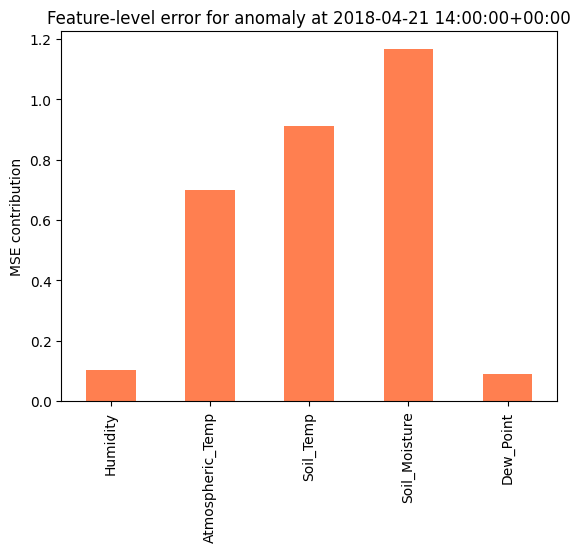

In [ ]:
import matplotlib.pyplot as plt

top_anomaly = results[results['anomaly']].iloc[0]
top_anomaly[features].plot(kind='bar', color='coral')
plt.title(f"Feature-level error for anomaly at {top_anomaly['timestamp']}")
plt.ylabel("MSE contribution")
plt.show()


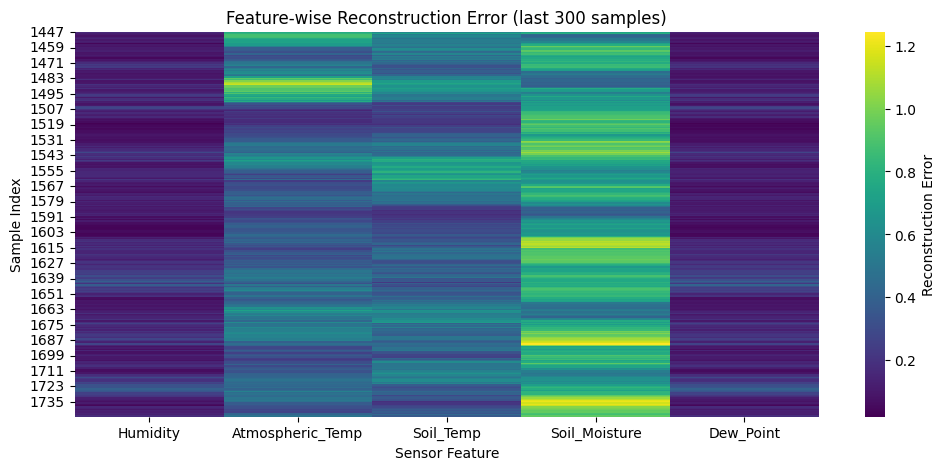

In [ ]:

 #Optional: Heatmap of feature-wise error

import seaborn as sns

plt.figure(figsize=(12,5))
sns.heatmap(results[features].iloc[-300:], cmap='viridis', cbar_kws={'label': 'Reconstruction Error'})
plt.title("Feature-wise Reconstruction Error (last 300 samples)")
plt.xlabel("Sensor Feature")
plt.ylabel("Sample Index")
plt.show()


/tmp/ipython-input-3713927788.py:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


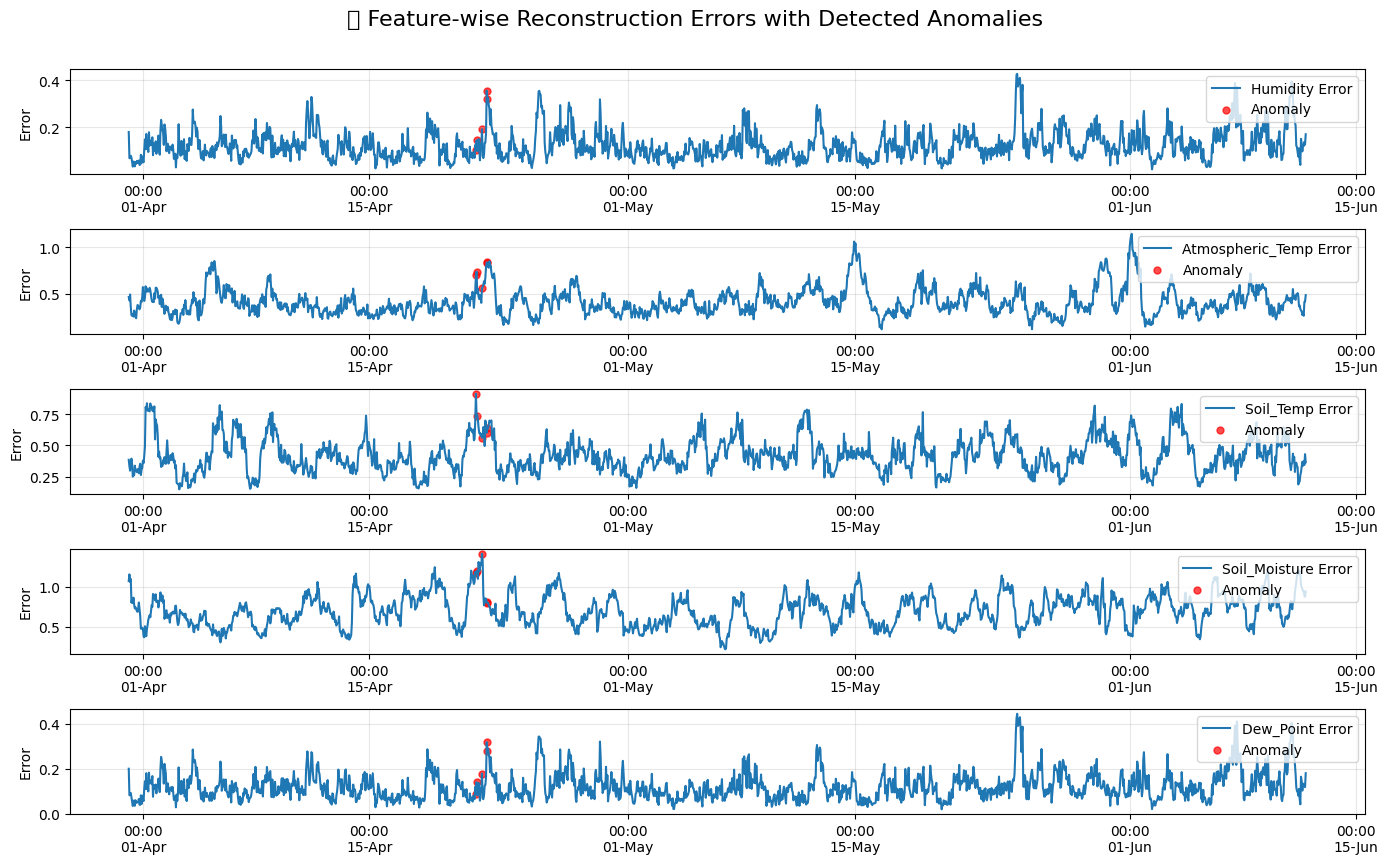

In [ ]:
# Interactive Dashboard-style Visualization

import matplotlib.dates as mdates

plt.figure(figsize=(14, 10))

# Plot each sensor’s reconstruction error
for i, feature in enumerate(features):
    plt.subplot(len(features)+1, 1, i+1)
    plt.plot(results['timestamp'], results[feature], label=f'{feature} Error', color='tab:blue')

    # Highlight anomalies for this feature
    plt.scatter(
        results[results['anomaly']]['timestamp'],
        results[results['anomaly']][feature],
        color='red', s=25, label='Anomaly', alpha=0.7
    )

    plt.ylabel("Error")
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))

plt.suptitle("🔍 Feature-wise Reconstruction Errors with Detected Anomalies", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()